In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Libraries
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Data

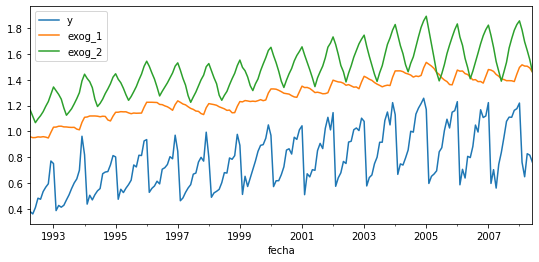

In [5]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

# ForecasterAutoregMultiOutput without exogenous variables

In [8]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(data_train.y)
forecaster

ForecasterAutoregMultiOutput 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Maximum steps predicted: 36 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 

Test error (mse): 0.010462358038493989


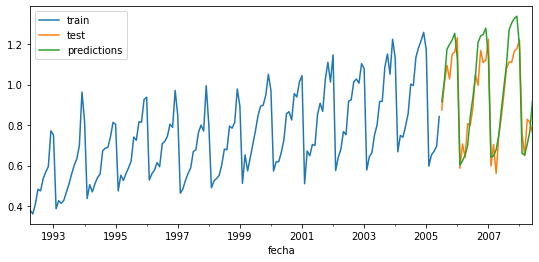

In [9]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [10]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 3
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [10, 50],
              'max_depth': [5, 10]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    =  int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(4)

Number of models compared: 12


loop lags_grid: 100%|█████████████████████████████| 3/3 [00:11<00:00,  4.00s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.030355,10,50
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.030453,5,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 10}",0.032194,10,10
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 10}",0.032301,5,10


In [11]:
# Predictors importance
# ==============================================================================
for step in range(forecaster.steps):
    print("Feature importance model step: ", step+1)
    display(forecaster.get_feature_importances(step=step+1))
    print("")

Feature importance model step:  1


,feature,importance
0,lag_1,0.447870
1,lag_2,0.187270
2,lag_3,0.097122
3,lag_4,0.027639
4,lag_5,0.025008
5,lag_6,0.018584
6,lag_7,0.028638
7,lag_8,0.026964
8,lag_9,0.044268
9,lag_10,0.096637



Feature importance model step:  2


,feature,importance
0,lag_1,0.116139
1,lag_2,0.082380
2,lag_3,0.026996
3,lag_4,0.033684
4,lag_5,0.013489
5,lag_6,0.038540
6,lag_7,0.026519
7,lag_8,0.052609
8,lag_9,0.095640
9,lag_10,0.514002



Feature importance model step:  3


,feature,importance
0,lag_1,0.075545
1,lag_2,0.009994
2,lag_3,0.018401
3,lag_4,0.008554
4,lag_5,0.007853
5,lag_6,0.013439
6,lag_7,0.025090
7,lag_8,0.044625
8,lag_9,0.022478
9,lag_10,0.774022



Feature importance model step:  4


,feature,importance
0,lag_1,0.025793
1,lag_2,0.035857
2,lag_3,0.006784
3,lag_4,0.009987
4,lag_5,0.014588
5,lag_6,0.018690
6,lag_7,0.041701
7,lag_8,0.026011
8,lag_9,0.812127
9,lag_10,0.008462



Feature importance model step:  5


,feature,importance
0,lag_1,0.027705
1,lag_2,0.007684
2,lag_3,0.011037
3,lag_4,0.014228
4,lag_5,0.017064
5,lag_6,0.032273
6,lag_7,0.025234
7,lag_8,0.809750
8,lag_9,0.008192
9,lag_10,0.046834



Feature importance model step:  6


,feature,importance
0,lag_1,0.007368
1,lag_2,0.014813
2,lag_3,0.015693
3,lag_4,0.017335
4,lag_5,0.038082
5,lag_6,0.020685
6,lag_7,0.807168
7,lag_8,0.007219
8,lag_9,0.051253
9,lag_10,0.020384



Feature importance model step:  7


,feature,importance
0,lag_1,0.015088
1,lag_2,0.016036
2,lag_3,0.017695
3,lag_4,0.031462
4,lag_5,0.018368
5,lag_6,0.798536
6,lag_7,0.007447
7,lag_8,0.061823
8,lag_9,0.013686
9,lag_10,0.019859



Feature importance model step:  8


,feature,importance
0,lag_1,0.021135
1,lag_2,0.016570
2,lag_3,0.028673
3,lag_4,0.030153
4,lag_5,0.816451
5,lag_6,0.007627
6,lag_7,0.042295
7,lag_8,0.016744
8,lag_9,0.011883
9,lag_10,0.008468



Feature importance model step:  9


,feature,importance
0,lag_1,0.019896
1,lag_2,0.034790
2,lag_3,0.045801
3,lag_4,0.786938
4,lag_5,0.006684
5,lag_6,0.054116
6,lag_7,0.017148
7,lag_8,0.015937
8,lag_9,0.013795
9,lag_10,0.004895



Feature importance model step:  10


,feature,importance
0,lag_1,0.024596
1,lag_2,0.029669
2,lag_3,0.819980
3,lag_4,0.009109
4,lag_5,0.048487
5,lag_6,0.017156
6,lag_7,0.017582
7,lag_8,0.016845
8,lag_9,0.008228
9,lag_10,0.008348



Feature importance model step:  11


,feature,importance
0,lag_1,0.023183
1,lag_2,0.832974
2,lag_3,0.006926
3,lag_4,0.062302
4,lag_5,0.010930
5,lag_6,0.014932
6,lag_7,0.009667
7,lag_8,0.007116
8,lag_9,0.007645
9,lag_10,0.024324



Feature importance model step:  12


,feature,importance
0,lag_1,0.839660
1,lag_2,0.013373
2,lag_3,0.059469
3,lag_4,0.014829
4,lag_5,0.013727
5,lag_6,0.006955
6,lag_7,0.007121
7,lag_8,0.006693
8,lag_9,0.027686
9,lag_10,0.010488



Feature importance model step:  13


,feature,importance
0,lag_1,0.399987
1,lag_2,0.203292
2,lag_3,0.084600
3,lag_4,0.045756
4,lag_5,0.033736
5,lag_6,0.028765
6,lag_7,0.017658
7,lag_8,0.050712
8,lag_9,0.027633
9,lag_10,0.107861



Feature importance model step:  14


,feature,importance
0,lag_1,0.122618
1,lag_2,0.021511
2,lag_3,0.042986
3,lag_4,0.048027
4,lag_5,0.032577
5,lag_6,0.033987
6,lag_7,0.022403
7,lag_8,0.053185
8,lag_9,0.101271
9,lag_10,0.521436



Feature importance model step:  15


,feature,importance
0,lag_1,0.035434
1,lag_2,0.025631
2,lag_3,0.028001
3,lag_4,0.010354
4,lag_5,0.009279
5,lag_6,0.028536
6,lag_7,0.014115
7,lag_8,0.060860
8,lag_9,0.031862
9,lag_10,0.755928



Feature importance model step:  16


,feature,importance
0,lag_1,0.033825
1,lag_2,0.025227
2,lag_3,0.011654
3,lag_4,0.010383
4,lag_5,0.030292
5,lag_6,0.013761
6,lag_7,0.055839
7,lag_8,0.040015
8,lag_9,0.758888
9,lag_10,0.020116



Feature importance model step:  17


,feature,importance
0,lag_1,0.027347
1,lag_2,0.007471
2,lag_3,0.009481
3,lag_4,0.026356
4,lag_5,0.014378
5,lag_6,0.055171
6,lag_7,0.030646
7,lag_8,0.735977
8,lag_9,0.014167
9,lag_10,0.079007



Feature importance model step:  18


,feature,importance
0,lag_1,0.010596
1,lag_2,0.013407
2,lag_3,0.021300
3,lag_4,0.017612
4,lag_5,0.036853
5,lag_6,0.038280
6,lag_7,0.739049
7,lag_8,0.011048
8,lag_9,0.094198
9,lag_10,0.017656



Feature importance model step:  19


,feature,importance
0,lag_1,0.010705
1,lag_2,0.024444
2,lag_3,0.014835
3,lag_4,0.048447
4,lag_5,0.026656
5,lag_6,0.733104
6,lag_7,0.014938
7,lag_8,0.085418
8,lag_9,0.020028
9,lag_10,0.021425



Feature importance model step:  20


,feature,importance
0,lag_1,0.022622
1,lag_2,0.016718
2,lag_3,0.047202
3,lag_4,0.028603
4,lag_5,0.740239
5,lag_6,0.010101
6,lag_7,0.090305
7,lag_8,0.012860
8,lag_9,0.015825
9,lag_10,0.015526



Feature importance model step:  21


,feature,importance
0,lag_1,0.011453
1,lag_2,0.053941
2,lag_3,0.036563
3,lag_4,0.732493
4,lag_5,0.013028
5,lag_6,0.088556
6,lag_7,0.015849
7,lag_8,0.020737
8,lag_9,0.017167
9,lag_10,0.010213



Feature importance model step:  22


,feature,importance
0,lag_1,0.055232
1,lag_2,0.027268
2,lag_3,0.740626
3,lag_4,0.010844
4,lag_5,0.102268
5,lag_6,0.014575
6,lag_7,0.008867
7,lag_8,0.017362
8,lag_9,0.010544
9,lag_10,0.012415



Feature importance model step:  23


,feature,importance
0,lag_1,0.051934
1,lag_2,0.746472
2,lag_3,0.011357
3,lag_4,0.109899
4,lag_5,0.011403
5,lag_6,0.008123
6,lag_7,0.015025
7,lag_8,0.014517
8,lag_9,0.010677
9,lag_10,0.020593



Feature importance model step:  24


,feature,importance
0,lag_1,0.789874
1,lag_2,0.011376
2,lag_3,0.088637
3,lag_4,0.013677
4,lag_5,0.010781
5,lag_6,0.015387
6,lag_7,0.013095
7,lag_8,0.017381
8,lag_9,0.026533
9,lag_10,0.013259



Feature importance model step:  25


,feature,importance
0,lag_1,0.393386
1,lag_2,0.202043
2,lag_3,0.057091
3,lag_4,0.045246
4,lag_5,0.029286
5,lag_6,0.030602
6,lag_7,0.023913
7,lag_8,0.033844
8,lag_9,0.027945
9,lag_10,0.156645



Feature importance model step:  26


,feature,importance
0,lag_1,0.127690
1,lag_2,0.035830
2,lag_3,0.036736
3,lag_4,0.057807
4,lag_5,0.024547
5,lag_6,0.041326
6,lag_7,0.037485
7,lag_8,0.035629
8,lag_9,0.096980
9,lag_10,0.505968



Feature importance model step:  27


,feature,importance
0,lag_1,0.042453
1,lag_2,0.024128
2,lag_3,0.016894
3,lag_4,0.017398
4,lag_5,0.010548
5,lag_6,0.028471
6,lag_7,0.009988
7,lag_8,0.089928
8,lag_9,0.030386
9,lag_10,0.729805



Feature importance model step:  28


,feature,importance
0,lag_1,0.045248
1,lag_2,0.023188
2,lag_3,0.015639
3,lag_4,0.007908
4,lag_5,0.023138
5,lag_6,0.012703
6,lag_7,0.085913
7,lag_8,0.039380
8,lag_9,0.714940
9,lag_10,0.031943



Feature importance model step:  29


,feature,importance
0,lag_1,0.016478
1,lag_2,0.010362
2,lag_3,0.011566
3,lag_4,0.032047
4,lag_5,0.008543
5,lag_6,0.113596
6,lag_7,0.017358
7,lag_8,0.698886
8,lag_9,0.007514
9,lag_10,0.083651



Feature importance model step:  30


,feature,importance
0,lag_1,0.014973
1,lag_2,0.014033
2,lag_3,0.023769
3,lag_4,0.014188
4,lag_5,0.091940
5,lag_6,0.022370
6,lag_7,0.702474
7,lag_8,0.012050
8,lag_9,0.094135
9,lag_10,0.010067



Feature importance model step:  31


,feature,importance
0,lag_1,0.014361
1,lag_2,0.028358
2,lag_3,0.008687
3,lag_4,0.092189
4,lag_5,0.036293
5,lag_6,0.687757
6,lag_7,0.009312
7,lag_8,0.089121
8,lag_9,0.013788
9,lag_10,0.020134



Feature importance model step:  32


,feature,importance
0,lag_1,0.020185
1,lag_2,0.010943
2,lag_3,0.112864
3,lag_4,0.017752
4,lag_5,0.704755
5,lag_6,0.008006
6,lag_7,0.086322
7,lag_8,0.008944
8,lag_9,0.019605
9,lag_10,0.010625



Feature importance model step:  33


,feature,importance
0,lag_1,0.008990
1,lag_2,0.112789
2,lag_3,0.030401
3,lag_4,0.709111
4,lag_5,0.009366
5,lag_6,0.080157
6,lag_7,0.011885
7,lag_8,0.013552
8,lag_9,0.010964
9,lag_10,0.012785



Feature importance model step:  34


,feature,importance
0,lag_1,0.073323
1,lag_2,0.049091
2,lag_3,0.716796
3,lag_4,0.007988
4,lag_5,0.093439
5,lag_6,0.012428
6,lag_7,0.008222
7,lag_8,0.010131
8,lag_9,0.013629
9,lag_10,0.014952



Feature importance model step:  35


,feature,importance
0,lag_1,0.069620
1,lag_2,0.732485
2,lag_3,0.012599
3,lag_4,0.091426
4,lag_5,0.013745
5,lag_6,0.013670
6,lag_7,0.012267
7,lag_8,0.015166
8,lag_9,0.016253
9,lag_10,0.022769



Feature importance model step:  36


,feature,importance
0,lag_1,0.778386
1,lag_2,0.017317
2,lag_3,0.083181
3,lag_4,0.014077
4,lag_5,0.019885
5,lag_6,0.012219
6,lag_7,0.012493
7,lag_8,0.016891
8,lag_9,0.010522
9,lag_10,0.035029


In [19]:
# Backtesting
# ==============================================================================
steps = 65
n_backtest = 65*2
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]


forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = steps,
                    lags      = 15
             )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    initial_train_size = len(data_train),
    steps      = steps,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

-14


ValueError: negative dimensions are not allowed

In [14]:
predicciones_backtest

,pred
1997-09-01,0.719722
1997-10-01,0.822415
1997-11-01,0.536321
1997-12-01,0.160598
1998-01-01,0.870073
...,...
2008-02-01,1.106928
2008-03-01,0.594868
2008-04-01,0.705355
2008-05-01,0.923467


In [10]:
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
np.allclose(predicciones_backtest.pred, np.concatenate([predictions_1, predictions_2, predictions_3]))

True

# ForecasterAutoregMultiOutput with 1 exogenous variables

In [11]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [12]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = Ridge(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=data_train.y, exog=data_train.exog_1)
forecaster

<class 'skforecast.ForecasterAutoregMultiOutput.ForecasterAutoregMultiOutput.ForecasterAutoregMultiOutput'> 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Maximum steps predicted: 36 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

Test error (mse): 0.00810760566140999


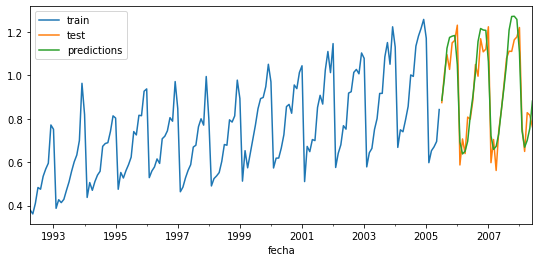

In [13]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test.exog_1)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [14]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 10
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid.head(4)

Number of models compared: 12


loop lags_grid: 100%|█████████████████████████████| 3/3 [00:29<00:00,  9.79s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'max_depth': 10, 'n_estimators': 100}



,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.042035,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.042439,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.042818,10,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.042879,5,50


In [15]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = steps,
                lags      = 5 
             )


metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    exog       = data.exog_1,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

Number of observations used for training or as initial window: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
[0.09317934]


In [16]:
# Verificar predicciones de backtesting
forecaster.fit(y=data_train.y, exog=data_train.exog_1)
predictions_1 = forecaster.predict(steps=steps, exog=data_test.exog_1[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps], exog=data_test.exog_1[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2], exog=data_test.exog_1[steps*2:steps*3])
np.allclose(predicciones_backtest.pred, np.concatenate([predictions_1, predictions_2, predictions_3]))

True

# ForecasterAutoregMultiOutput with multiple exogenous variables

In [17]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [18]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])
forecaster

<class 'skforecast.ForecasterAutoregMultiOutput.ForecasterAutoregMultiOutput.ForecasterAutoregMultiOutput'> 
Regressor: RandomForestRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Maximum steps predicted: 36 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 

Test error (mse): 0.005123860986630349


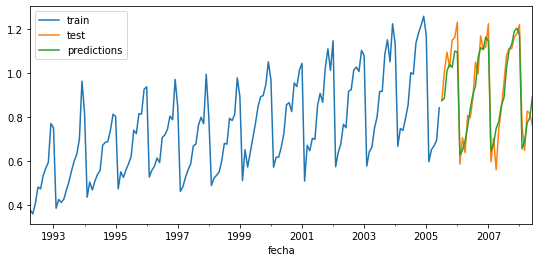

In [19]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [21]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

Number of models compared: 12


loop lags_grid: 100%|█████████████████████████████| 3/3 [00:29<00:00,  9.75s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'max_depth': 10, 'n_estimators': 100}



,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.036602,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.037905,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.037950,10,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.037955,5,50
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.038550,10,100
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.039878,10,50
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.040262,5,100
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.041510,5,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.044292,5,50
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.045461,5,100


# Información de sesión

In [ ]:
import session_info
session_info.show(html=False, write_req_file=False)